In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import time
import math
import seaborn as sns

from src.mazeworld import WallAutoCollectMazeWorld, LimitedCollectWallMazeWorld, SimpleWallMazeWorld, SimpleWallMazeWorld2
from src.mdp import MDP, LegibleTaskMDP, LearnerMDP, Utilities, MiuraLegibleMDP
from tqdm import tqdm
from itertools import combinations
np.set_printoptions(precision=9, linewidth=2000, threshold=10000, suppress=True)
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
def get_goal_states(states, goal, with_objs=True, goals=[]):

    if with_objs:
        state_lst = list(states)
        return [state_lst.index(x) for x in states if x.find(goal) != -1]
    else:
        for g in goals:
            if g[2].find(goal) != -1:
                return str(g[0]) + ' ' + str(g[1])

def get_initial_states(states, task_locs):

    return [state for state in states if state.find('N') != -1] + \
           [str(e[0]) + ' ' + str(e[1]) + ' ' + e[2] for e in task_locs]

def simulate(mdp, pol, mdp_tasks, leg_pol, x0, n_trajs, goal):

    mdp_trajs = []
    tasks_trajs = []

    for _ in tqdm(range(n_trajs), desc='Simulate Trajectories'):
        traj, acts = mdp.trajectory(x0, pol)
        traj_leg, acts_leg = mdp_tasks.trajectory(x0, leg_pol)
        mdp_trajs += [[traj, acts]]
        tasks_trajs += [[traj_leg, acts_leg]]

    mdp_r = mdp.trajectory_reward(mdp_trajs)
    mdp_rl = mdp_tasks.trajectory_reward(mdp_trajs, goal)
    task_r = mdp.trajectory_reward(tasks_trajs)
    task_rl = mdp_tasks.trajectory_reward(tasks_trajs, goal)

    return mdp_r, mdp_rl, task_r, task_rl

In [9]:
def create_world_view(n_rows, n_cols, obj_place, walls=None):
    
    fig = plt.figure(figsize=(15, 15))
    #fig = plt.figure()
    ax = fig.add_subplot()
    plt.xlim(0, n_cols)
    plt.ylim(0,  n_rows)
    plt.xticks([i + 1 for i in range(n_cols)])
    plt.yticks([i + 1 for i in range(n_rows)])
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', left=False, right=False)
    ax.set_xticklabels('')
    ax.xaxis.set_minor_locator(ticker.FixedLocator([x + 0.5 for x in range(n_cols + 1)]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([str(x) for x in range(1, n_cols + 1)]))
    ax.set_yticklabels('')
    ax.yaxis.set_minor_locator(ticker.FixedLocator([x + 0.5 for x in range(n_rows + 1)]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter([str(x) for x in range(1, n_rows + 1)]))
    plt.grid(True)

    for obj in obj_place:
        x = obj[1] - 0.5
        y = obj[0] - 0.5
        o = '$' + obj[2] + '$'
        
        plt.plot(x, y, marker=o, color='k', markersize=10)
    
    if walls:
        for wall in walls:
            wall_sec = np.array([list(wall_elem) for wall_elem in wall])
            plt.plot(wall_sec[:, 1] - 0.5, wall_sec[:, 0] - 0.5, color='k', linewidth=5)
    
    return fig, ax


def visualize_trajectory(x0, trajectory, figure, color, goal, zorder):
    
    actions = {'U': (0, 0.8), 'D': (0, -0.8), 'L':(-0.8, 0), 'R':(0.8, 0), 'G': (0, 0), 'P':(0, 0), 'N': (0, 0)}
    ax = figure[1]
    
    plt.plot(x0[0]-0.5, x0[1]-0.5, marker='o', markersize=15, color='dimgrey', zorder=0)
    plt.plot(goal[1]-0.5, goal[0]-0.5, marker='x', markersize=20, color='gold')
    for ptr in trajectory:
        x = ptr[0]-0.5
        y = ptr[1]-0.5
        a = actions[ptr[2]]
        if ptr[2] in ['U', 'D', 'L', 'R']:
            ax.arrow(x, y, a[0], a[1], head_width=0.1, head_length=0.1, lw=1.5, fc=color, ec=color, zorder=zorder)
        else:
            ax.add_patch(plt.Circle((x, y), 0.3, linewidth=1.7, fill=False, color=color))

def draw_policy_states(figure, pol, goal_states, state_lst, action_lst, states, color, objs=True):
    
    actions = {'U': (0, 0.8), 'D': (0, -0.8), 'L':(-0.8, 0), 'R':(0.8, 0), 'G': (0, 0), 'P':(0, 0), 'N': (0, 0)}
    ax = figure[1]
    
    for state in states:
        state_idx = state_lst.index(state)
        if objs:
            state_split = re.match(r"([0-9]+) ([0-9]+) ([a-z]+)", state, re.I)
        else:
            state_split = re.match(r"([0-9]+) ([0-9]+)", state, re.I)
        y = int(state_split.group(1)) - 0.5
        x = int(state_split.group(2)) - 0.5
        if state_lst.index(state) in goal_states:
            ax.add_patch(plt.Circle((x, y), 0.3, linewidth=1.7, color='gold', zorder=0))
        pol_actions = np.nonzero(pol[state_idx, :])[0]
        for action in pol_actions:
            act = action_lst[action]
            a = actions[act]
            if act in ['U', 'D', 'L', 'R']:
                ax.arrow(x, y, a[0], a[1], head_width=0.1, head_length=0.1, lw=1.5, fc=color, ec=color)
            else:
                ax.add_patch(plt.Circle((x, y), 0.3, linewidth=1.7, fill=False, color=color))
        
def process_trajectory(trajectory, actions, objs=True):
    
    traj = []
    
    for i in range(len(trajectory) - 1):
        if objs:
            state_split = re.match(r"([0-9]+) ([0-9]+) ([a-z]+)", trajectory[i], re.I)
        else:
            state_split = re.match(r"([0-9]+) ([0-9]+)", trajectory[i], re.I)
        y = int(state_split.group(1))
        x = int(state_split.group(2))
        
        traj += [(x, y, actions[i])]
    
    return traj

<IPython.core.display.Javascript object>


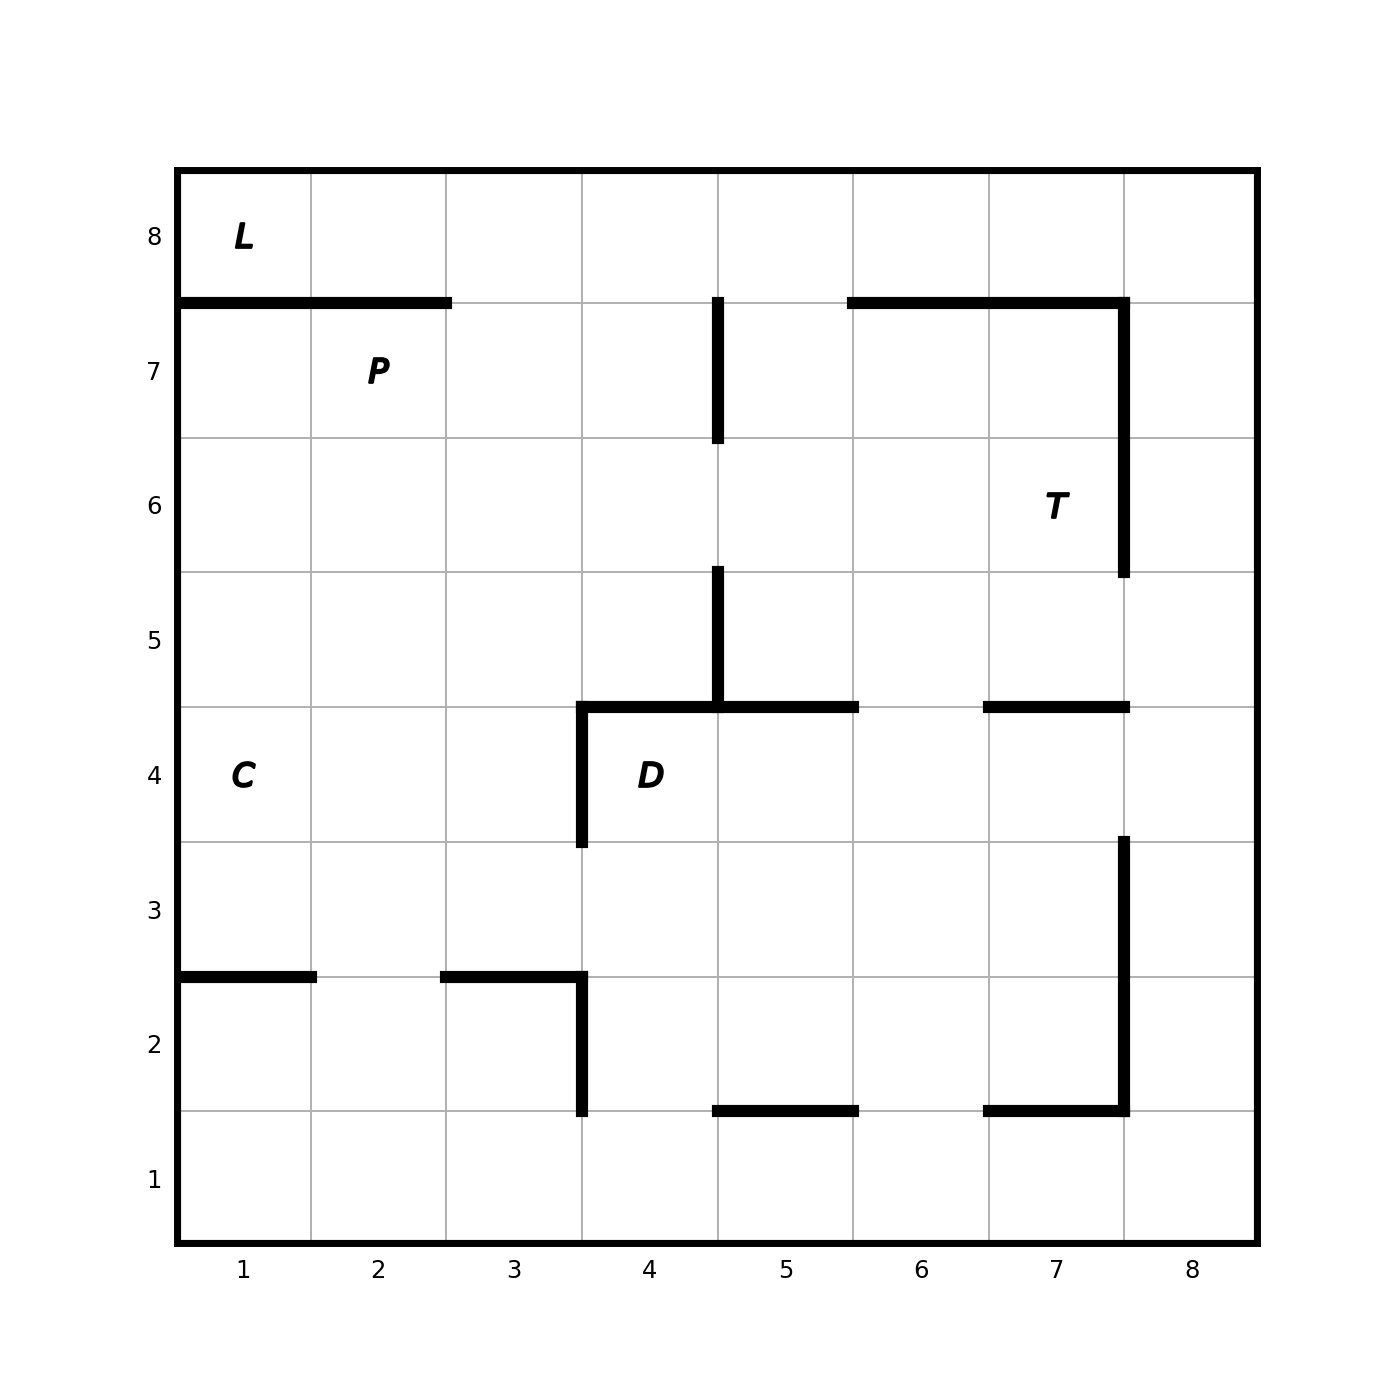

In [4]:
n_rows = 8
n_cols = 8
# objs_states = [(7, 2, 'P'), (4, 4, 'D'), (4, 1, 'C'), (8, 1, 'L'), (6, 7, 'T'), (8, 8, 'O')]
objs_states = [(7, 2, 'P'), (4, 4, 'D'), (4, 1, 'C'), (8, 1, 'L'), (6, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(1.5, 3.5), (2.5, 3.5)],
         [(3.5, 3.5), (4.5, 3.5)],
         [(2.5, 0.5), (2.5, 1.5)],
         [(2.5, 2.5), (2.5, 3.5)],
         [(1.5, x + 0.5) for x in range(4, 6)],
         [(1.5, 6.5), (1.5, 7.5)],
         [(7.5, x + 0.5) for x in range(0, 3)],
         [(7.5, x + 0.5) for x in range(5, 8)],
         [(x + 0.5, 4.5) for x in range(4, 6)],
         [(x + 0.5, 4.5) for x in range(6, 8)],
         [(4.5, x + 0.5) for x in range(3, 6)],
         [(4.5, x + 0.5) for x in range(6, 8)],
         [(x + 0.5, 7.5) for x in range(1, 4)],
         [(x + 0.5, 7.5) for x in range(5, 8)]]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'T'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 8
n_cols = 8
# objs_states = [(6, 1, 'P'), (1, 7, 'D'), (3, 2, 'C'), (8, 1, 'L'), (7, 7, 'T'), (8, 8, 'O')]
objs_states = [(6, 1, 'P'), (1, 7, 'D'), (3, 2, 'C'), (8, 1, 'L'), (7, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 3.5), (1.5, 3.5), (2.5, 3.5)],
         [(x + 0.5, 4.5) for x in range(4, 6)],
         [(x + 0.5, 4.5) for x in range(6, 8)],
         [(x + 0.5, 2.5) for x in range(2, 5)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 7.5) for x in range(1, 3)],
         [(x + 0.5, 7.5) for x in range(3, 8)],
         [(2.5, 0.5), (2.5, 1.5), (2.5, 2.5)],
         [(2.5, x + 0.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(5, 7)],
         [(7.5, x + 0.5) for x in range(0, 2)],
         [(7.5, x + 0.5) for x in range(5, 8)],
         [(4.5, x + 0.5) for x in range(4, 6)],
         [(4.5, x + 0.5) for x in range(6, 8)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'T'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 8
n_cols = 8
# objs_states = [(8, 5, 'P'), (1, 5, 'D'), (4, 1, 'C'), (8, 1, 'L'), (4, 7, 'T'), (8, 8, 'O')]
objs_states = [(8, 5, 'P'), (1, 5, 'D'), (4, 1, 'C'), (8, 1, 'L'), (4, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(6, 8)],
         [(x + 0.5, 5.5) for x in range(6, 9)],
         [(x + 0.5, 6.5) for x in range(3, 6)],
         [(x + 0.5, 6.5) for x in range(6, 8)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(1.5, x + 0.5) for x in range(3, 6)],
         [(1.5, x + 0.5) for x in range(6, 9)],
         [(3.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(0, 3)],
         [(6.5, x + 0.5) for x in range(3, 5)],
         [(6.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(7, 9)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'P'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 10
n_cols = 10
objs_states = [(9, 3, 'P'), (9, 1, 'D'), (1, 6, 'C'), (5, 4, 'L'), (10, 8, 'T'), (7, 9, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 2.5), (1.5, 2.5)],
         [(3.5, 6.5), (3.5, 7.5)],
         [(3.5, 0.5), (3.5, 1.5)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 10)],
         [(x + 0.5, 6.5) for x in range(0, 3)],
         [(x + 0.5, 8.5) for x in range(3, 8)],
         [(x + 0.5, 8.5) for x in range(8, 11)],
         [(3.5, x + 0.5) for x in range(2, 6)],
         [(3.5, x + 0.5) for x in range(8, 10)],
         [(8.5, x + 0.5) for x in range(2, 4)],
         [(8.5, x + 0.5) for x in range(4, 8)]]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'O'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


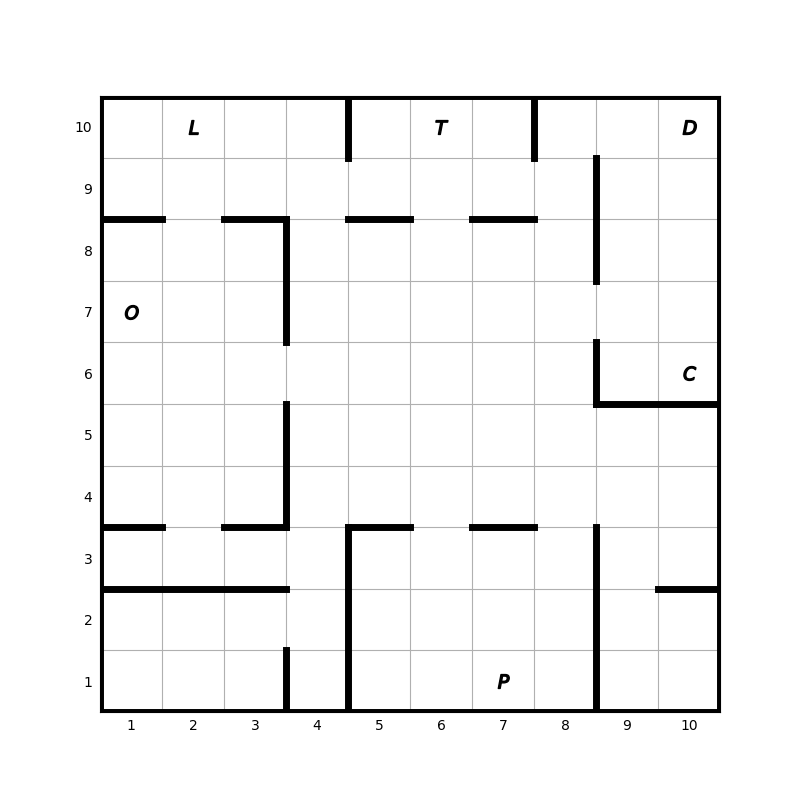

In [56]:
n_rows = 10
n_cols = 10
objs_states = [(1, 7, 'P'), (10, 10, 'D'), (6, 10, 'C'), (10, 2, 'L'), (10, 6, 'T'), (7, 1, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 3.5), (1.5, 3.5)],
         [(x + 0.5, 3.5) for x in range(3, 6)],
         [(x + 0.5, 3.5) for x in range(6, 9)],
         [(x + 0.5, 4.5) for x in range(0, 4)],
         [(x + 0.5, 4.5) for x in range(9, 11)],
         [(x + 0.5, 7.5) for x in range(9, 11)],
         [(x + 0.5, 8.5) for x in range(0, 4)],
         [(x + 0.5, 8.5) for x in range(7, 10)],
         [(x + 0.5, 8.5) for x in range(5, 7)],
         [(2.5, x + 0.5) for x in range(0, 4)],
         [(2.5, x + 0.5) for x in range(9, 11)],
         [(8.5, x + 0.5) for x in range(0, 2)],
         [(8.5, x + 0.5) for x in range(2, 4)],
         [(8.5, x + 0.5) for x in range(4, 6)],
         [(8.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(8, 11)],
         [(3.5, x + 0.5) for x in range(0, 2)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(3.5, x + 0.5) for x in range(4, 6)],
         [(3.5, x + 0.5) for x in range(6, 8)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'T'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 10
n_cols = 10
objs_states = [(1, 7, 'P'), (10, 10, 'D'), (7, 10, 'C'), (9, 1, 'L'), (9, 5, 'T'), (5, 1, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 6.5) for x in range(4, 7)], 
         [(x + 0.5, 4.5) for x in range(4, 7)],
         [(x + 0.5, 2.5) for x in range(3, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 1.5) for x in range(8, 10)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(8, 11)],
         [(x + 0.5, 4.5) for x in range(0, 3)],
         [(x + 0.5, 7.5) for x in range(0, 3)],
         [(x + 0.5, 7.5) for x in range(8, 11)],
         [(x + 0.5, 8.5) for x in range(0, 4)],
         [(x + 0.5, 8.5) for x in range(4, 7)],
         [(x + 0.5, 8.5) for x in range(8, 10)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(2.5, x + 0.5) for x in range(4, 6)],
         [(2.5, x + 0.5) for x in range(6, 8)],
         [(3.5, x + 0.5) for x in range(0, 3)],
         [(3.5, x + 0.5) for x in range(9, 11)],
         [(4.5, x + 0.5) for x in range(9, 11)],
         [(4.5, x + 0.5) for x in range(4, 7)],
         [(6.5, x + 0.5) for x in range(4, 7)],
         [(7.5, x + 0.5) for x in range(0, 3)],
         [(7.5, x + 0.5) for x in range(8, 11)],
         [(8.5, x + 0.5) for x in range(0, 2)],
         [(8.5, x + 0.5) for x in range(3, 6)],
         [(8.5, x + 0.5) for x in range(6, 8)],
         [(8.5, x + 0.5) for x in range(8, 10)]
        ]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'C'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 10
n_cols = 10
objs_states = [(8, 3, 'P'), (5, 7, 'D'), (5, 2, 'C'), (8, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 1.5) for x in range(2, 10)],
         [(x + 0.5, 3.5) for x in range(0, 3)],
         [(x + 0.5, 3.5) for x in range(3, 7)],
         [(x + 0.5, 3.5) for x in range(7, 9)],
         [(x + 0.5, 5.5) for x in range(7, 9)],
         [(x + 0.5, 6.5) for x in range(0, 3)],
         [(x + 0.5, 6.5) for x in range(4, 7)],
         [(x + 0.5, 8.5) for x in range(4, 6)],
         [(x + 0.5, 8.5) for x in range(7, 9)],
         [(x + 0.5, 9.5) for x in range(2, 10)],
         [(2.5, x + 0.5) for x in range(1, 3)],
         [(2.5, x + 0.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(5, 7)],
         [(2.5, x + 0.5) for x in range(8, 10)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(4.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(2, 4)],
         [(6.5, x + 0.5) for x in range(6, 9)],
         [(7.5, x + 0.5) for x in range(1, 4)],
         [(7.5, x + 0.5) for x in range(5, 9)],
         [(9.5, x + 0.5) for x in range(1, 3)],
         [(9.5, x + 0.5) for x in range(3, 7)],
         [(9.5, x + 0.5) for x in range(7, 10)]
        ]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'T']
goal = 'T'
max_goal_len = max([len(g) for g in goals]) + 2

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


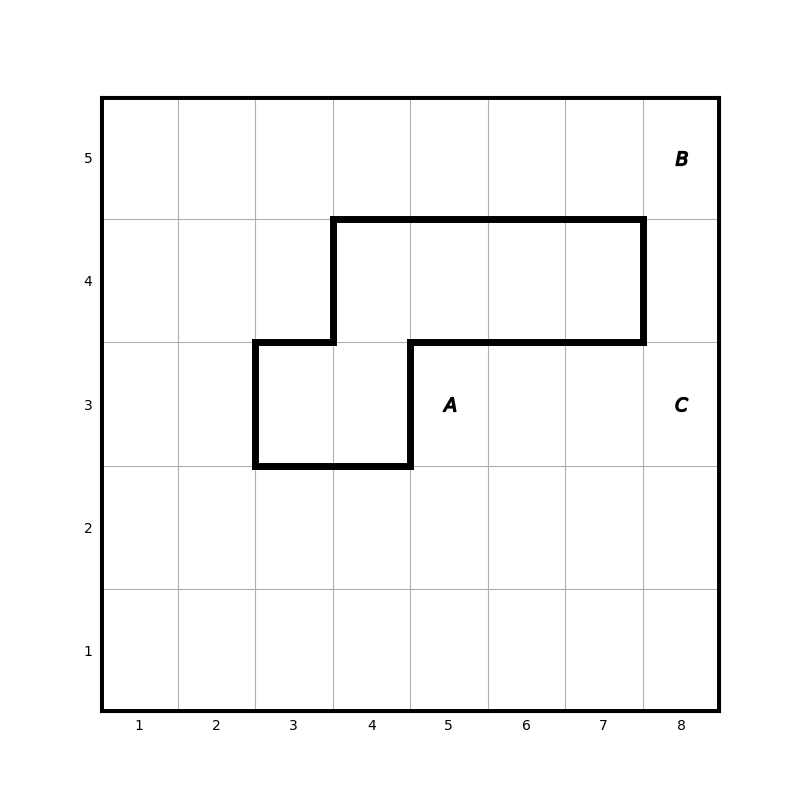

In [66]:
n_rows = 5
n_cols = 8
objs_states = [(3, 5, 'A'), (5, 8, 'B'), (3, 8, 'C')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 2.5) for x in range(2, 4)],
         [(x + 0.5, 4.5) for x in range(2, 4)],
         [(x + 0.5, 3.5) for x in range(3, 5)],
         [(x + 0.5, 7.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(2, 5)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(3.5, x + 0.5) for x in range(4, 8)],
         [(4.5, x + 0.5) for x in range(3, 8)]
        ]
x0 = '1 1 N'
goals = ['A', 'B', 'C']
goal = 'B'
max_goal_len = max([len(g) for g in goals]) + 2

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 5
n_cols = 8
objs_states = [(1, 3, 'A'), (5, 6, 'B'), (3, 8, 'C')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 3.5) for x in range(0, 3)],
         [(x + 0.5, 4.5) for x in range(0, 3)],
         [(2.5, x + 0.5) for x in range(3, 5)]
        ]
x0 = '3 1 N'
goals = ['A', 'B', 'C']
goal = 'C'
max_goal_len = max([len(g) for g in goals]) + 2

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
n_rows = 5
n_cols = 8
objs_states = [(5, 4, 'A'), (5, 1, 'B'), (5, 7, 'C')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 1.5) for x in range(2, 4)],
         [(x + 0.5, 2.5) for x in range(2, 4)],
         [(x + 0.5, 7.5) for x in range(2, 4)],
         [(2.5, x + 0.5) for x in range(0, 2)],
         [(2.5, x + 0.5) for x in range(2, 8)],
         [(3.5, x + 0.5) for x in range(0, 2)],
         [(3.5, x + 0.5) for x in range(2, 8)]
        ]
x0 = '1 1 N'
goals = ['A', 'B', 'C']
goal = 'C'
max_goal_len = max([len(g) for g in goals]) + 2

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [78]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
beta = 0.5
max_goal_len = max([len(g) for g in goals]) + 1
# wacmw = WallAutoCollectMazeWorld()
# wacmw = LimitedCollectWallMazeWorld()
# wacmw = SimpleWallMazeWorld()
wacmw = SimpleWallMazeWorld2()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15)
with_objs = True
goal_states = get_goal_states(X_w, goal)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
v_mdps_w = {}
q_mdps_w = {}
task_mdps_w = {}
dists = []
costs = []
rewards = {}
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    # c = wacmw.generate_costs(goals[i], X_w, A_w)
    c = wacmw.generate_rewards(goals[i], X_w, A_w)
    costs += [c]
    rewards[goals[i]] = c
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]), 'rewards')
    pol, q = mdp.policy_iteration()
    v = Utilities.v_from_q(q, pol)
    q_mdps_w[goals[i]] = q
    v_mdps_w[goals[i]] = v
    dists += [mdp.policy_dist(pol)]
    # print(dists)
    mdps_w['mdp' + str(i + 1)] = mdp
dists = np.array(dists)
print('Legible task MDP')
task_mdp_w = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goal, objs_states, goals, beta, goal_states, 1, 
                     'leg_optimal', q_mdps=q_mdps_w, v_mdps=v_mdps_w, dists=dists)

leg_costs = [task_mdp_w.costs[idx] for idx in range(len(goals))]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration(goals.index(goal))
print('Took %.3f seconds to compute policy' % (time.time() - time1))

##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
### Computing Costs and Creating Task MDPs ###


Single Task MDPs: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.40it/s]

N. iterations:  3
N. iterations:  3
N. iterations:  3
Legible task MDP
### Computing Optimal policy ###
N. iterations: 

 3
Took 0.008 seconds to compute policy
### Computing Legible policy ###
N. iterations:  4
Took 0.010 seconds to compute policy


In [68]:
nonzerostates = np.nonzero(q_mdps_w[goal].sum(axis=1))[0]
print(nonzerostates)
clean_states = [np.delete(nonzerostates, np.argwhere(nonzerostates == g)) for g in goal_states][0]
count = np.zeros(len(X_w))
for i in range(10000):
    count[np.random.choice(clean_states)] += 1
print(count)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25 26 31 32 33 34 35 36 37 38 39]
[302. 280. 305. 304. 301. 308. 314. 317. 288. 280. 302. 313. 315. 291. 356. 326. 274. 294.   0.   0. 309. 311. 295. 280. 302. 311. 297.   0.   0.   0.   0. 320. 289. 275. 315. 287. 301. 324. 314.   0.]


In [ ]:
beta = 0.3
depth = 20
n_its = 50000
miura_mdp = MiuraLegibleMDP(X_w, A_w, P_w, 0.9, goal, goals, beta, goal_states, q_mdps=q_mdps_w)
x0 = '1 1 N'
time1 = time.time()
miura_traj = miura_mdp.legible_trajectory(x0, pol_w, depth, n_its, beta)
print('Took %.3f seconds to compute trajectory' % (time.time() - time1))
print(miura_traj)

In [ ]:
print('Miura trajectory')
goal_state = objs_states[goals.index(goal)]
i = 0
traj, a_traj = miura_traj
p_traj = process_trajectory(traj, a_traj)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]], goals.index(goal))))
t_leg = process_trajectory(task_traj, task_act)
figure = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(p_traj[0], p_traj, figure, 'blue', goal_state, zorder=0)
visualize_trajectory(t_leg[0], t_leg, figure, 'k', goal_state, zorder=1)
fig, _ = figure
fig.show()

In [ ]:
q_pi_mdps = []
for i in range(len(goals)):
    q_pi_mdps += [q_mdps_w[goals[i]]]
q_pi_mdps = np.array(q_pi_mdps)
print(task_mdp_w.policy_legibility(q_pi_mdps, v_mdps_w, len(X_w), len(A_w), len(goals), 0.025, goals)[goals.index(goal)])

q_pi_mdps_l = []
v_mdps_l = []
for g in range(len(goals)):
    mdp_l = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[g], objs_states, goals, beta, get_goal_states(X_w, goals[g]), 1, 
                           'leg_optimal', q_mdps=q_mdps_w, v_mdps=v_mdps_w)
    pol_l, q_pi_l = task_mdp_w.policy_iteration(goals.index(goal))
    v_l = Utilities.v_from_q(q, pol)
    q_pi_mdps_l += [q_pi_l]
    v_mdps_l += [v_l]
q_pi_mdps_l = np.array(q_pi_mdps_l)
v_mdps_l = np.array(v_mdps_l)
print(task_mdp_w.policy_legibility(q_pi_mdps_l, v_mdps_w, len(X_w), len(A_w), len(goals), 0.025, goals)[goals.index(goal)])

In [ ]:
states = X_w
print('Goal: ' + goal)
opt_figure = create_world_view(n_rows, n_cols, objs_states, walls)
draw_policy_states(opt_figure, pol_w, list(X_w), list(A_w), states, 'b', with_objs)
fig, _ = opt_figure
fig.show()
opt_leg_pol = np.isclose(opt_leg_pol, opt_leg_pol.max(axis=1, keepdims=True), atol=1e-8, rtol=1e-8).astype(int)
opt_leg_pol = opt_leg_pol / opt_leg_pol.sum(axis=1, keepdims=True)
leg_figure = create_world_view(n_rows, n_cols, objs_states, walls)
draw_policy_states(leg_figure, opt_leg_pol, list(X_w), list(A_w), states, 'k', with_objs)
fig, _ = leg_figure
fig.show()

In [ ]:
for x in X_w:
    print('State: %s' % x)
    for g in goals:
        print('Goal: %s V = %s\tQ = %s' % (g, str(v_mdps_w[g][list(X_w).index(x)]), str(q_mdps_w[g][list(X_w).index(x)])))
        # print('Goal: %s adv = %s' % (g, str(leg_costs[goals.index(g)][list(X_w).index(x)])))

In [ ]:
# states = get_initial_states(X_w, objs_states)
states = X_w
print('Goal: ' + goal)
opt_figure = create_world_view(n_rows, n_cols, objs_states, walls)
draw_policy_states(opt_figure, pol_w, goal_states, list(X_w), list(A_w), states, 'b', with_objs)
fig, _ = opt_figure
fig.show()
leg_figure = create_world_view(n_rows, n_cols, objs_states, walls)
draw_policy_states(leg_figure, task_pol_w, goal_states, list(X_w), list(A_w), states, 'k', with_objs)
fig, _ = leg_figure
fig.show()
# for x in states:
#     print('State %s' % x)
#     x_idx = list(X_w).index(x)
#     state_cost_sum = 0
#     for g_idx in range(len(goals)):
#         print('Goal: %s' % goals[g_idx], end=' ')
#         print(leg_costs[g_idx][x_idx])
#         state_cost_sum += leg_costs[g_idx][x_idx]
#     print('Goal: %s Q Values ' % goal, end=' ')
#     print(task_Q[x_idx])
#     print(state_cost_sum)
#     print('-------------------------------------------------')

Initial State: 1 1 N
##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
Optimal trajectory for task: B
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '2 3 N' '2 4 N' '2 5 N' '2 6 N' '3 6 N' '3 7 N' '3 8 C' '4 8 N' '5 8 B']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Cost: 0.31381059609000017


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.41it/s]


Legible Reward: 2.033749555360062
Legible trajectory for task: B
Trajectory: ['1 1 N' '2 1 N' '3 1 N' '4 1 N' '4 1 N' '5 1 N' '5 2 N' '5 3 N' '5 4 N' '5 5 N' '5 6 N' '5 7 N' '5 8 B']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Cost: 0.28242953648100017


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Legible Reward: 3.0245290868402552


<IPython.core.display.Javascript object>


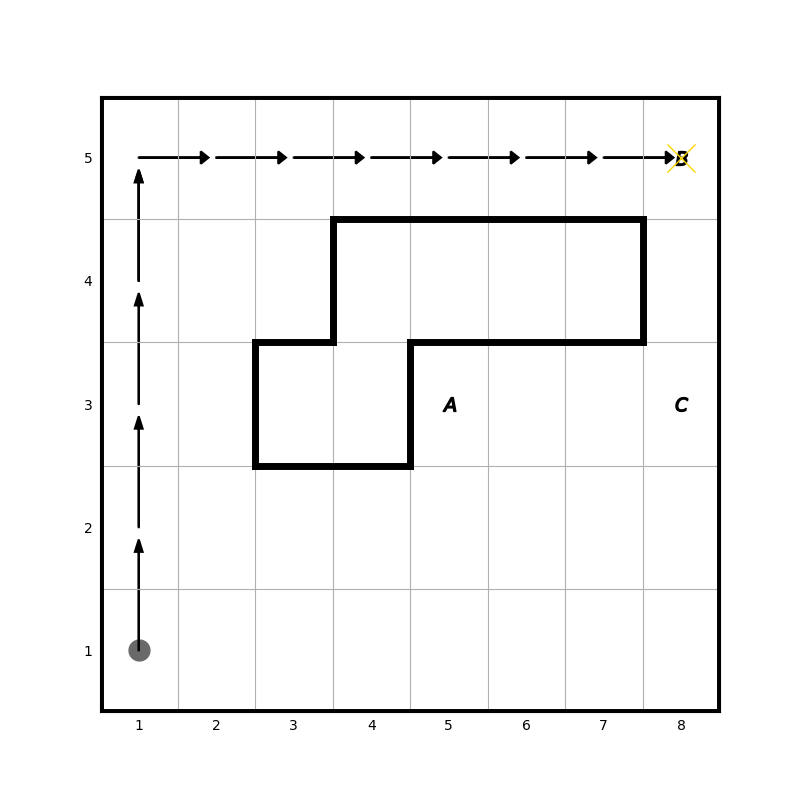

In [75]:
x0 = '1 1 N'
goal_state = objs_states[goals.index(goal)]
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[t1, a1]], goals.index(goal))))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]], goals.index(goal))))
t_leg = process_trajectory(task_traj, task_act)

figure = create_world_view(n_rows, n_cols, objs_states, walls)
#visualize_trajectory(t_opt[0], t_opt, figure, 'b', goal_state, zorder=0)
visualize_trajectory(t_leg[0], t_leg, figure, 'k', goal_state, zorder=1)
fig, _ = figure
fig.show()

# print('Getting model performance!!')
# clock_1 = time.time()
# mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
#                                                 task_mdp_w, task_pol_w, x0, 1000, goals.index(goal))
# time_simulation = time.time() - clock_1
# print('Simulation length = %.3f' % time_simulation)
# print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
# print('Legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

Optimal trajectories: 66


<IPython.core.display.Javascript object>


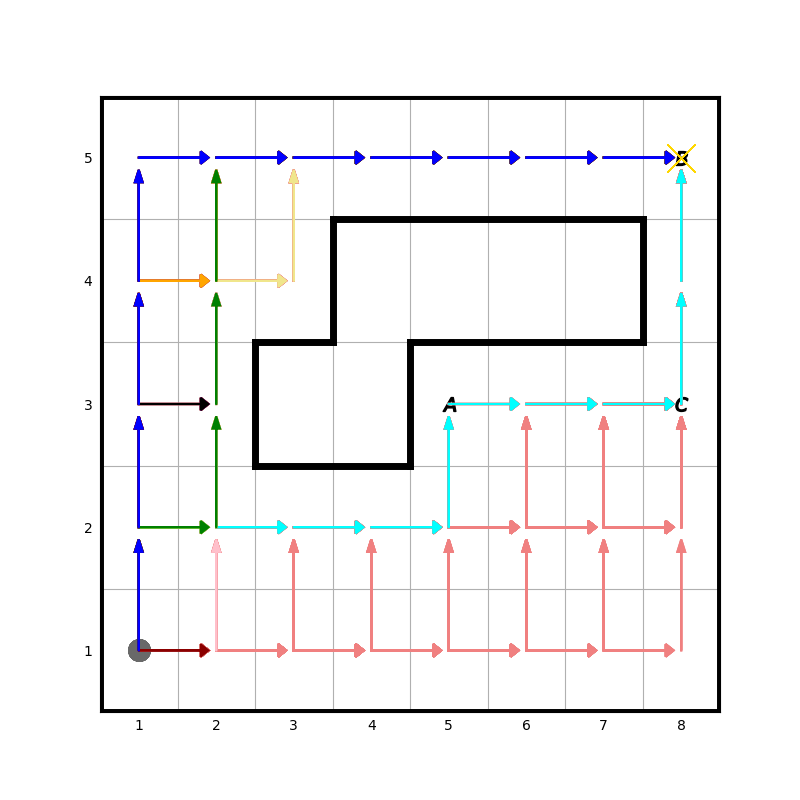

Legible trajectories: 1


<IPython.core.display.Javascript object>


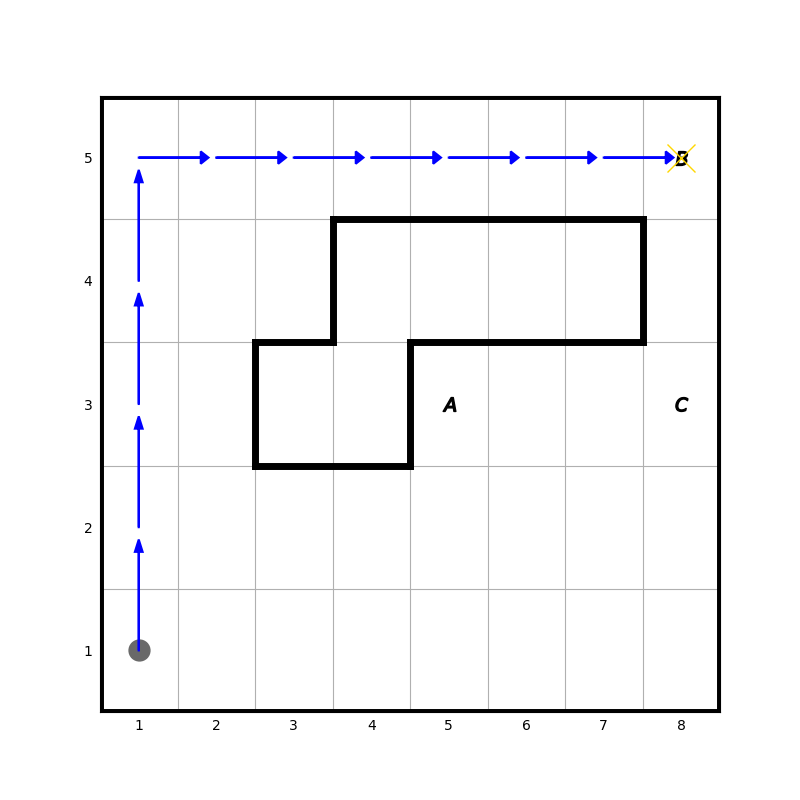

In [76]:
colors = ['blue', 'darkred', 'green', 'black', 'orange', 'pink', 'yellow', 'magenta', 'brown', 'cyan', 'khaki', 'olivedrab', 'lightcoral']
trajs, a_trajs = mdps_w['mdp' + str(goals.index(goal) + 1)].all_trajectories(x0, pol_w)
print('Optimal trajectories: %d' % len(trajs))
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(trajs)):
    traj = trajs[j]
    a_traj = a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors) - 1)], goal_state, zorder=(len(trajs) - j))
    i += 1
fig, _ = fig
fig.show()
leg_trajs, leg_a_trajs = task_mdp_w.all_trajectories(x0, task_pol_w)
print('Legible trajectories: %d' % len(leg_trajs))
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(leg_trajs)):
    traj = leg_trajs[j]
    a_traj = leg_a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors) - 1)], goal_state, zorder=(len(trajs) - j))
    i += 1
fig, _ = fig
fig.show()

Goal: A
N. iterations:  3
N. iterations:  4


<IPython.core.display.Javascript object>


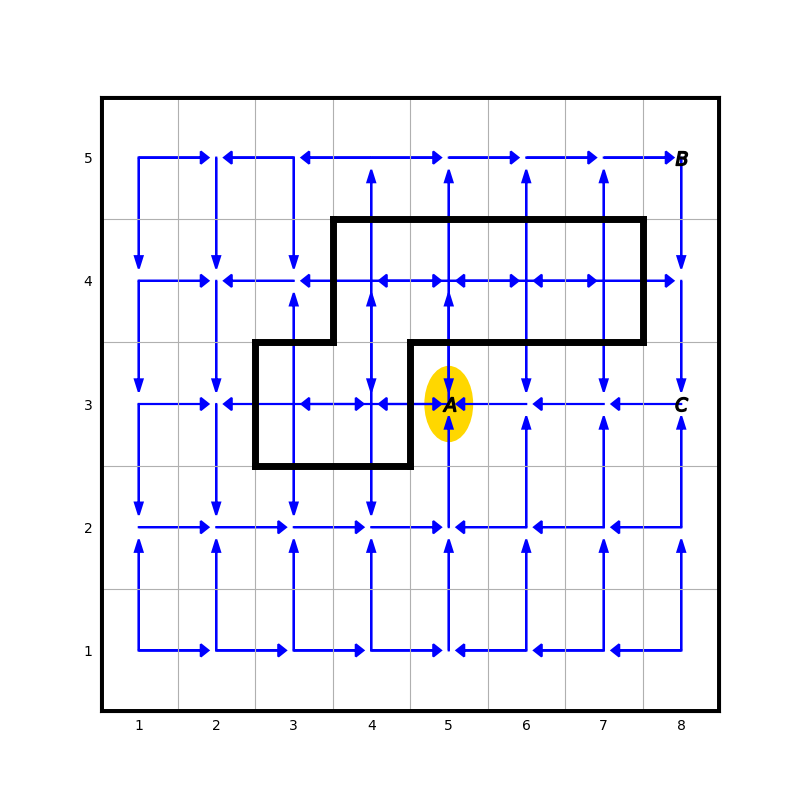

<IPython.core.display.Javascript object>


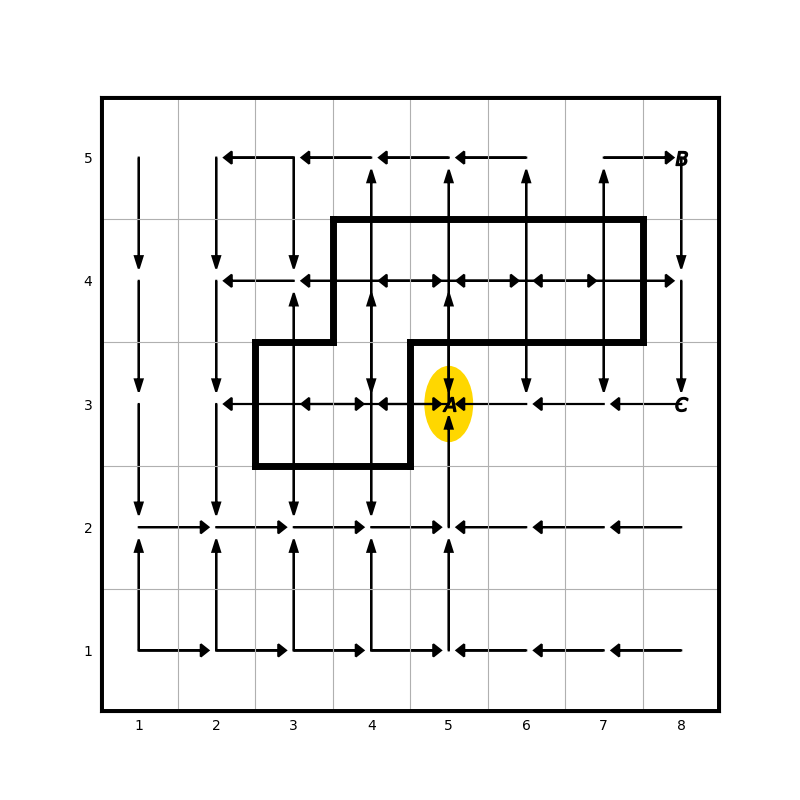

Goal: B
N. iterations:  3
N. iterations:  4


<IPython.core.display.Javascript object>


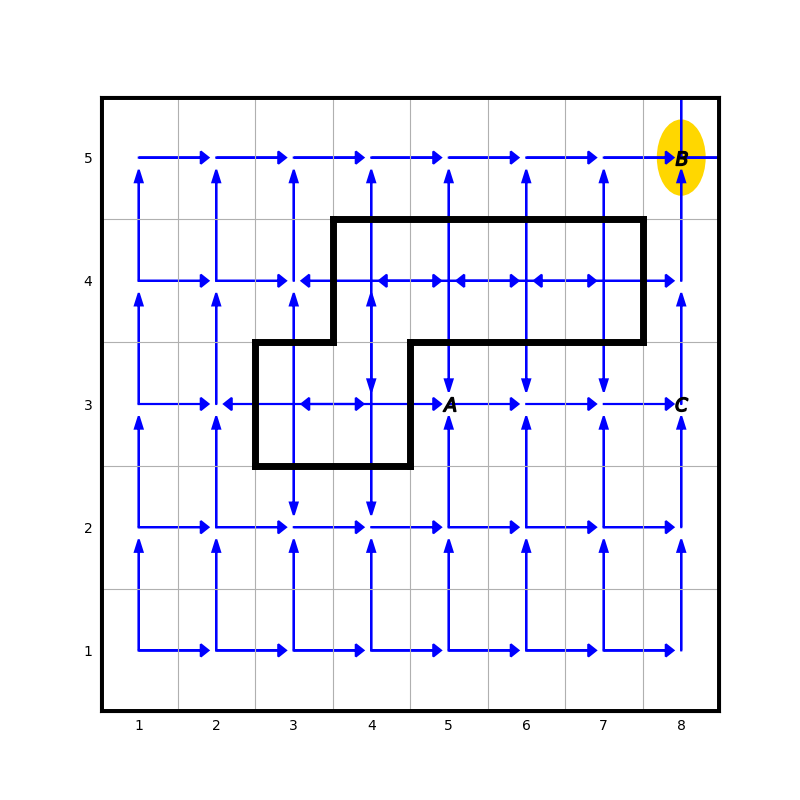

<IPython.core.display.Javascript object>


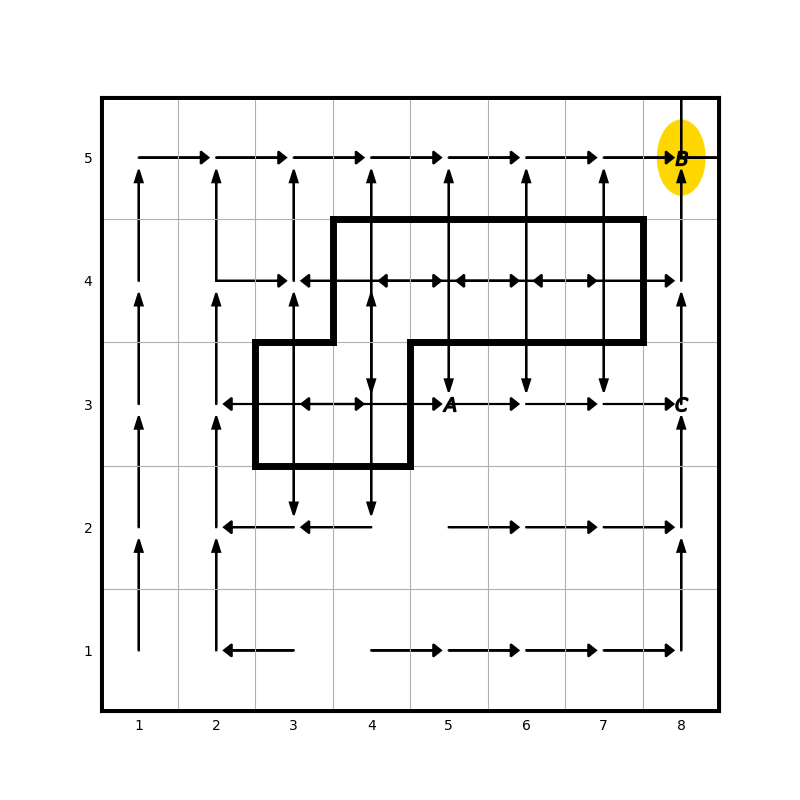

Goal: C
N. iterations:  3
N. iterations:  6


<IPython.core.display.Javascript object>


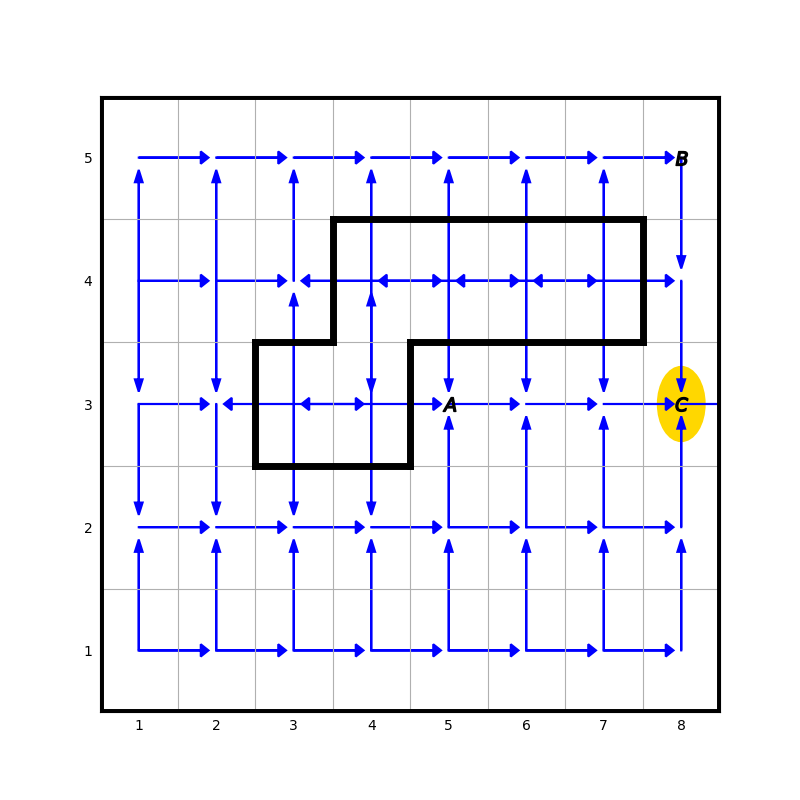

<IPython.core.display.Javascript object>


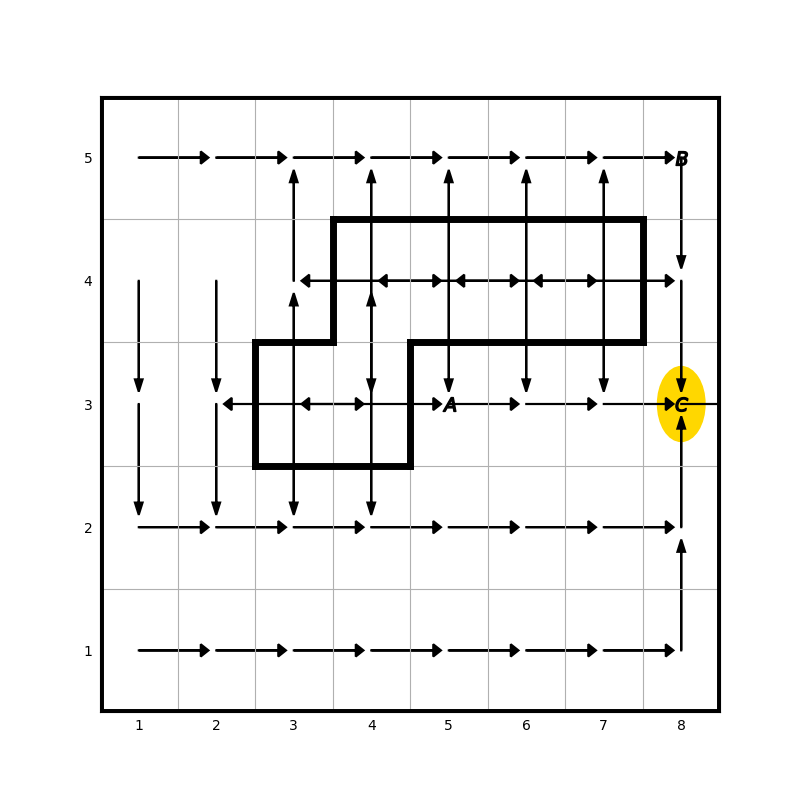

In [79]:
# states = get_initial_states(X_w, objs_states)
states = X_w
leg_qs = []
for g in goals:
    print('Goal: ' + g)
    opt_mdp = mdps_w['mdp' + str(goals.index(g) + 1)]
    opt_pol, _ = opt_mdp.policy_iteration()
    leg_pol, leg_q = task_mdp_w.policy_iteration(goals.index(g))
    leg_qs += [leg_q]
    opt_figure = create_world_view(n_rows, n_cols, objs_states, walls)
    draw_policy_states(opt_figure, opt_pol, get_goal_states(X_w, g), list(X_w), list(A_w), states, 'b', with_objs)
    fig, _ = opt_figure
    fig.show()
    leg_figure = create_world_view(n_rows, n_cols, objs_states, walls)
    draw_policy_states(leg_figure, leg_pol, get_goal_states(X_w, g), list(X_w), list(A_w), states, 'k', with_objs)
    fig, _ = leg_figure
    fig.show()

In [ ]:
for x in states:
    print('State %s' % x)
    x_idx = list(X_w).index(x)
    state_cost_sum = 0
    state_q_sum = 0
    for g_idx in range(len(goals)):
        print('Goal: %s' % goals[g_idx], end=' ')
        print(leg_costs[g_idx][x_idx], leg_qs[g_idx][x_idx])
        state_cost_sum += leg_costs[g_idx][x_idx]
        state_q_sum += leg_qs[g_idx][x_idx]
    print(state_cost_sum, state_q_sum)
    print('-------------------------------------------------')

In [ ]:
states = get_initial_states(X_w, objs_states)

for g in goals:
    
    goal_idx = goals.index(g)
    opt_mdp = mdps_w['mdp' + str(goals.index(g) + 1)]
    leg_mdp = task_mdps_w['leg_mdp_' + str(goal_idx + 1)]
    
    opt_pol, _ = opt_mdp.policy_iteration()
    leg_pol, _ = leg_mdp.policy_iteration()
    
    opt_pol_cost = task_mdp_w.policy_cost(opt_pol, states)
    leg_pol_cost = task_mdp_w.policy_cost(leg_pol, states)    
    print(g, opt_pol_cost, leg_pol_cost)

In [ ]:
n_rows = 5
n_cols = 4
objs_states = [(3, 4, 'P'), (3, 1, 'D'), (5, 2, 'C')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(1.5, x + 0.5) for x in range(0, 2)],
         [(1.5, x + 0.5) for x in range(2, 4)],
         [(4.5, x + 0.5) for x in range(1, 3)],
         [(x + 0.5, 1.5) for x in range(1, 4)],
         [(x + 0.5, 2.5) for x in range(1, 3)],
        ]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C']
goal = 'P'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [ ]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
wacmw = WallAutoCollectMazeWorld()
wacmw = SimpleWallMazeWorld2()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
q_mdps_w = []
task_mdps_w = {}
costs = []
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = wacmw.generate_costs(goals[i], X_w, A_w)
    costs += [c]
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]), 'costs')
    _, q = mdp.policy_iteration()
    q_mdps_w += [q]
    mdps_w['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
for i in tqdm(range(len(goals)), desc='Legible Task MDPs'):
    mdp = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[i], objs_states, goals, 1.0, get_goal_states(X_w, goals[i]), 
                         -1, 'leg_optimal', q_mdps=q_mdps_w)
    task_mdps_w['leg_mdp_' + str(i + 1)] = mdp
task_mdp_w = task_mdps_w['leg_mdp_' + str(goals.index(goal) + 1)]
leg_costs = [task_mdp_w.costs[idx] for idx in range(len(goals))]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration(goals.index(goal))
print('Took %.3f seconds to compute policy' % (time.time() - time1))

In [ ]:
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward(goals.index(goal), [[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward(goals.index(goal), [[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig, _ = fig
fig.show()

# states = get_initial_states(X_w, objs_states)
states = X_w
for state in states:
    print('State: %s' % (state))
    for g in goals:
        print('Goal %s Q-Values %s' % (g, str(q_mdps_w[goals.index(g)][list(X_w).index(state)])))
    print('Cost: ' + str(leg_costs[goals.index(goal)][list(X_w).index(state)]))

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
                                                task_mdp_w, task_pol_w, x0, 1000, goals.index(goal))
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

In [ ]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

In [ ]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

In [ ]:
n_rows = 8
n_cols = 8
objs_states = [(8, 5, 'P'), (1, 5, 'D'), (6, 70, 'C'), (8, 1, 'L'), (4, 7, 'T'), (8, 8, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(6, 8)],
         [(x + 0.5, 5.5) for x in range(6, 9)],
         [(x + 0.5, 6.5) for x in range(3, 6)],
         [(x + 0.5, 6.5) for x in range(6, 8)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(1.5, x + 0.5) for x in range(3, 6)],
         [(1.5, x + 0.5) for x in range(6, 9)],
         [(3.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(0, 3)],
         [(6.5, x + 0.5) for x in range(3, 5)],
         [(6.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(7, 9)]
        ]

fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()
print(np.array(walls, dtype=object))

<IPython.core.display.Javascript object>


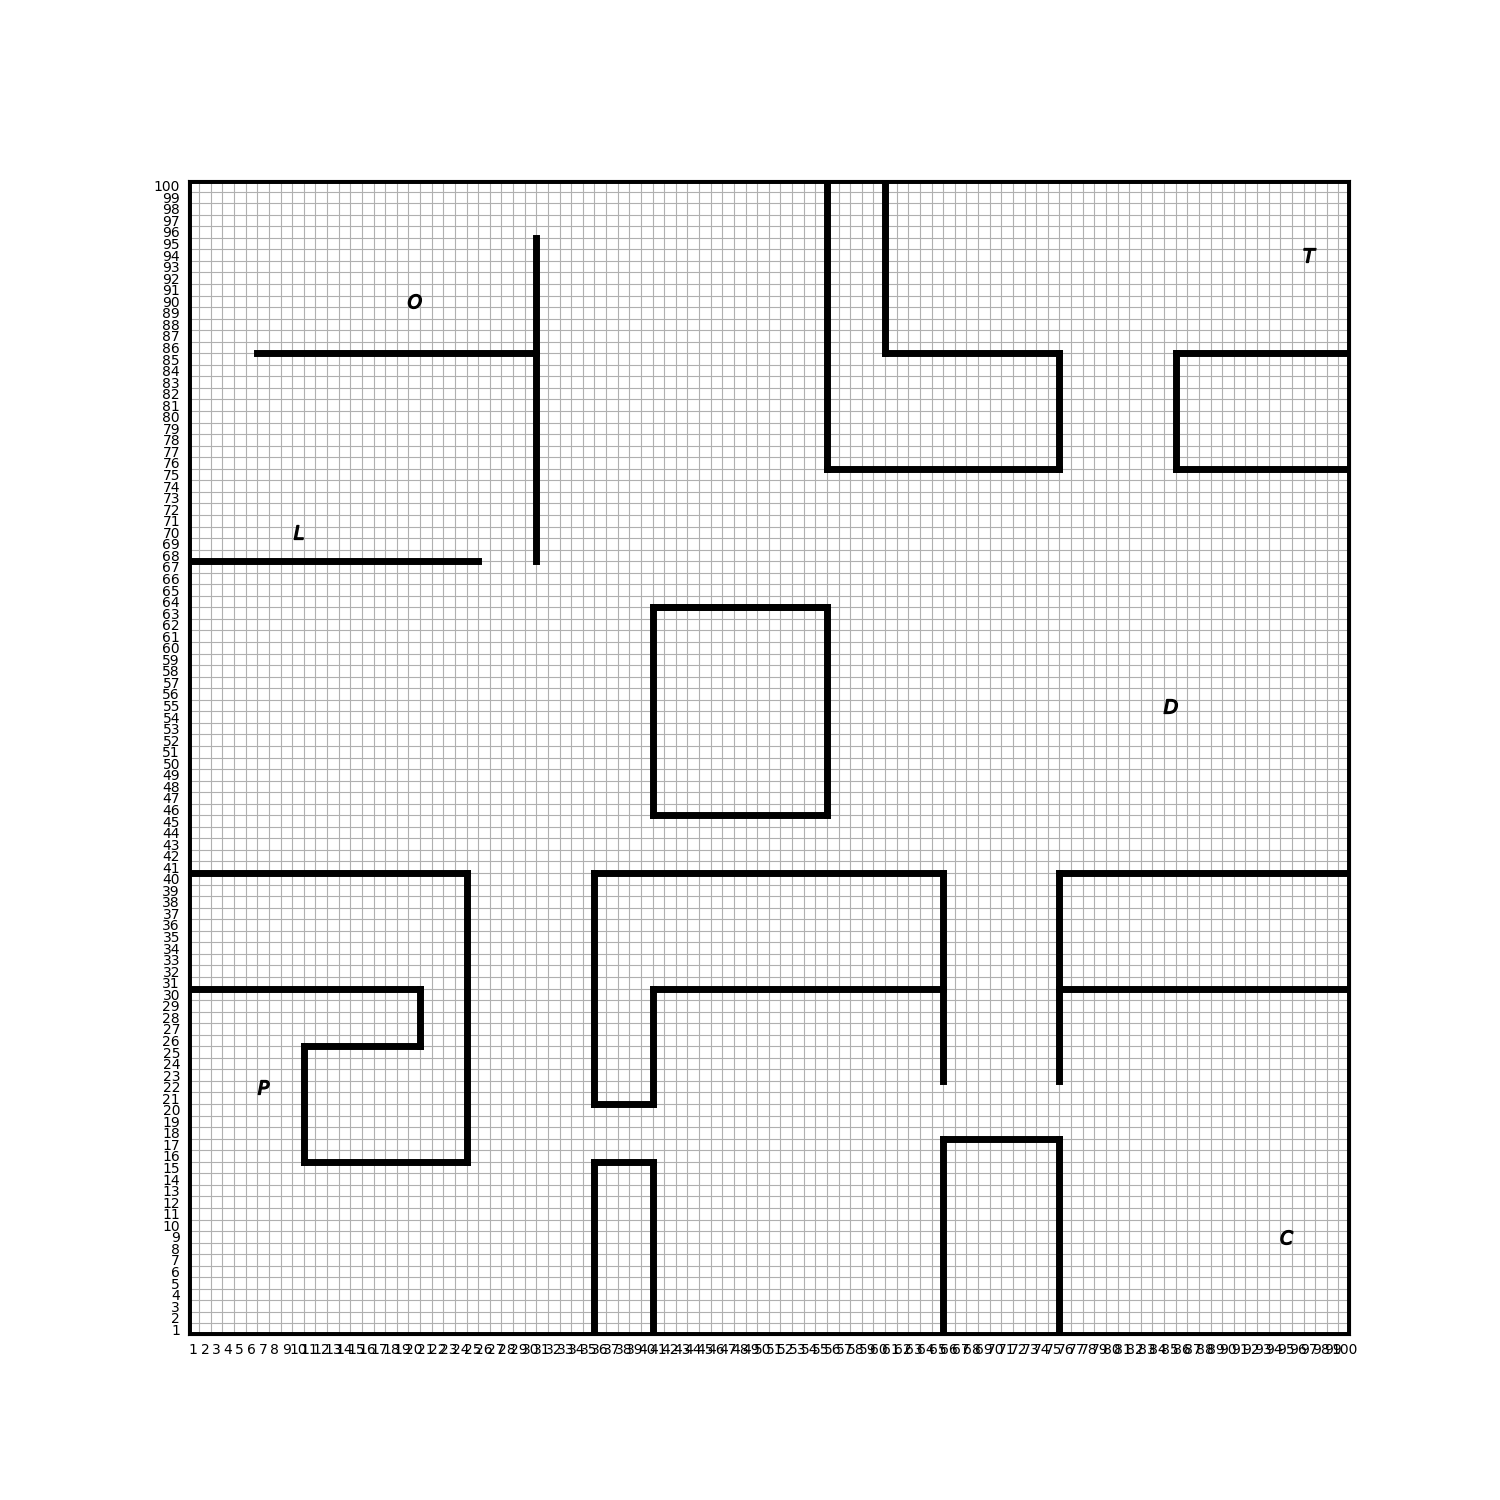

[list([(0.5, 0.5), (0.5, 1.5), (0.5, 2.5), (0.5, 3.5), (0.5, 4.5), (0.5, 5.5), (0.5, 6.5), (0.5, 7.5), (0.5, 8.5), (0.5, 9.5), (0.5, 10.5), (0.5, 11.5), (0.5, 12.5), (0.5, 13.5), (0.5, 14.5), (0.5, 15.5), (0.5, 16.5), (0.5, 17.5), (0.5, 18.5), (0.5, 19.5), (0.5, 20.5), (0.5, 21.5), (0.5, 22.5), (0.5, 23.5), (0.5, 24.5), (0.5, 25.5), (0.5, 26.5), (0.5, 27.5), (0.5, 28.5), (0.5, 29.5), (0.5, 30.5), (0.5, 31.5), (0.5, 32.5), (0.5, 33.5), (0.5, 34.5), (0.5, 35.5), (0.5, 36.5), (0.5, 37.5), (0.5, 38.5), (0.5, 39.5), (0.5, 40.5), (0.5, 41.5), (0.5, 42.5), (0.5, 43.5), (0.5, 44.5), (0.5, 45.5), (0.5, 46.5), (0.5, 47.5), (0.5, 48.5), (0.5, 49.5), (0.5, 50.5), (0.5, 51.5), (0.5, 52.5), (0.5, 53.5), (0.5, 54.5), (0.5, 55.5), (0.5, 56.5), (0.5, 57.5), (0.5, 58.5), (0.5, 59.5), (0.5, 60.5), (0.5, 61.5), (0.5, 62.5), (0.5, 63.5), (0.5, 64.5), (0.5, 65.5), (0.5, 66.5), (0.5, 67.5), (0.5, 68.5), (0.5, 69.5), (0.5, 70.5), (0.5, 71.5), (0.5, 72.5), (0.5, 73.5), (0.5, 74.5), (0.5, 75.5), (0.5, 76.5), (0

In [16]:
n_rows = 100
n_cols = 100
objs_states = [(22, 7, 'P'), (55, 85, 'D'), (9, 95, 'C'), (70, 10, 'L'), (94, 97, 'T'), (90, 20, 'O')]
# objs_states = [(27, 50, 'A'), (60, 50, 'B'), (9, 95, 'C'), (55, 85, 'D'), (54, 2, 'E'), (95, 54, 'F'),
#                (70, 10, 'L'), (90, 20, 'O'), (22, 7, 'P'), (94, 97, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(x + 0.5, 10.5) for x in range(15, 26)],
         [(x + 0.5, 20.5) for x in range(25, 31)],
         [(x + 0.5, 24.5) for x in range(15, 41)],
         [(x + 0.5, 30.5) for x in range(67, 96)],
         [(x + 0.5, 35.5) for x in range(0, 16)],
         [(x + 0.5, 35.5) for x in range(20, 41)],
         [(x + 0.5, 40.5) for x in range(45, 64)],
         [(x + 0.5, 40.5) for x in range(0, 16)],
         [(x + 0.5, 40.5) for x in range(20, 31)],
         [(x + 0.5, 55.5) for x in range(45, 64)],
         [(x + 0.5, 55.5) for x in range(75, 101)],
         [(x + 0.5, 60.5) for x in range(85, 101)],
         [(x + 0.5, 65.5) for x in range(0, 18)],
         [(x + 0.5, 65.5) for x in range(22, 41)],
         [(x + 0.5, 75.5) for x in range(75, 86)],
         [(x + 0.5, 75.5) for x in range(0, 18)],
         [(x + 0.5, 75.5) for x in range(22, 41)],
         [(x + 0.5, 85.5) for x in range(75, 86)],
         [(15.5, x + 0.5) for x in range(10, 25)],
         [(15.5, x + 0.5) for x in range(35, 41)],
         [(17.5, x + 0.5) for x in range(65, 76)],
         [(20.5, x + 0.5) for x in range(35, 41)],
         [(25.5, x + 0.5) for x in range(10, 21)],
         [(30.5, x + 0.5) for x in range(0, 21)],
         [(30.5, x + 0.5) for x in range(40, 66)],
         [(30.5, x + 0.5) for x in range(75, 101)],
         [(40.5, x + 0.5) for x in range(0, 25)],
         [(40.5, x + 0.5) for x in range(35, 66)],
         [(40.5, x + 0.5) for x in range(75, 101)],
         [(45.5, x + 0.5) for x in range(40, 56)],
         [(63.5, x + 0.5) for x in range(40, 56)],
         [(63.5, x + 0.5) for x in range(40, 56)],
         [(67.5, x + 0.5) for x in range(0, 26)],
         [(63.5, x + 0.5) for x in range(40, 56)],
         [(75.5, x + 0.5) for x in range(55, 76)],
         [(75.5, x + 0.5) for x in range(85, 101)],
         [(85.5, x + 0.5) for x in range(6, 31)],
         [(85.5, x + 0.5) for x in range(60, 76)],
         [(85.5, x + 0.5) for x in range(85, 101)],
        ]

# wacmw_test = SimpleWallMazeWorld2()
# X_w, A_w, P_w = wacmw_test.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15)
# print(len(X_w))
fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()
print(np.array(walls, dtype=object))